##### GLDADec (Our Proposed) deconvolution on TCGA-BRCA
- TCGA RNA-seq data were downloaded on November 16, 2022. 
- Due to memory problems, some files are not registered in this repository.Please contact us if necessary.
- Correspoinding to Fig. 6.

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = '/workspace/github/GLDADec' # cloning repository
import sys
sys.path.append(BASE_DIR)

from run import pipeline
from _utils import tcga_utils as tu

***
#### Load data

In [2]:
raw_df = pd.read_csv('/workspace/Topic_Deconv/GuidedLDA/230608_TCGA/230608_BRCA_analysis/230608_conduct_deconv/results/53561x1052_tmp.csv',index_col=0) # local data

breast_dic = pd.read_pickle(BASE_DIR+'/data/marker/human_breast_CellMarker.pkl')
random_sets = pd.read_pickle(BASE_DIR+'/data/random_info/100_random_sets.pkl')

***
#### Conduct GLDADec
- We added 100 genes with large coefficients of variation between samples.
- Distributions of each sample was normalized with QN.

In [3]:
pp = pipeline.Pipeline(verbose=False)
pp.from_predata(raw_df,target_samples=[],
                do_ann=False,linear2log=False,log2linear=False,do_drop=True,do_batch_norm=False,do_quantile=True)
pp.gene_selection(method='CV',outlier=False,topn=100)
pp.add_marker_genes(target_cells=[],add_dic=breast_dic)
pp.deconv_prep(random_sets=random_sets,do_plot=False,specific=True,prior_norm=True,norm_scale=1000,minmax=False,mm_scale=10)
pp.deconv(n=10,add_topic=1,n_iter=50,alpha=0.01,eta=0.01,refresh=10,initial_conf=1.0,seed_conf=1.0,other_conf=0.0,ll_plot=False,var_plot=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
merge_res = pp.merge_total_res
deconv_res = sum(merge_res) / len(merge_res)

***
#### BRCA subtype classification

In [5]:
brca_res = deconv_res.rename(columns={'1':'others'}) # rename

sample2id = pd.read_pickle(BASE_DIR+'/data/TCGA/sample2caseid_dic.pkl')
barcode2id = pd.read_pickle(BASE_DIR+'/data/TCGA/barcode2caseid_dic.pkl')

new_idx = [sample2id.get(x) for x in brca_res.index.tolist()]
brca_res.index = new_idx

info = pd.read_excel(BASE_DIR+'/data/TCGA/pone.0157368.s008.xlsx',index_col=0)
target_type = ['Basal','Her2','LumA','LumB','Normal']

/usr/local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


/tmp/ipykernel_2073208/2061561079.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_res['type']=[t]*len(common_res)
/tmp/ipykernel_2073208/2061561079.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_res['type']=[t]*len(common_res)
/tmp/ipykernel_2073208/2061561079.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

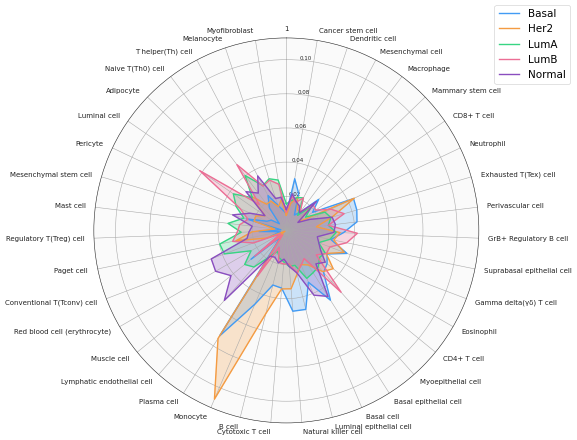

In [6]:
# Radarchart
data = []
summary_res = pd.DataFrame()
for t in target_type:
    tmp_df = info[info['PAM50']==t]

    target_caseid = []
    for b in tmp_df.index.tolist():
        for i,k in enumerate(barcode2id):
            if b in k:
                target_caseid.append(barcode2id.get(k))
            else:
                pass

    common_res = brca_res.loc[brca_res.index.isin(target_caseid)]
    common_v = common_res.mean()
    data.append(common_v)

    common_res['type']=[t]*len(common_res)
    summary_res = pd.concat([summary_res,common_res])

# radar chart
tu.plot_radar(data=data,labels=brca_res.columns.tolist(),conditions=target_type,title='',figsize=(10,10),dpi=50)


/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


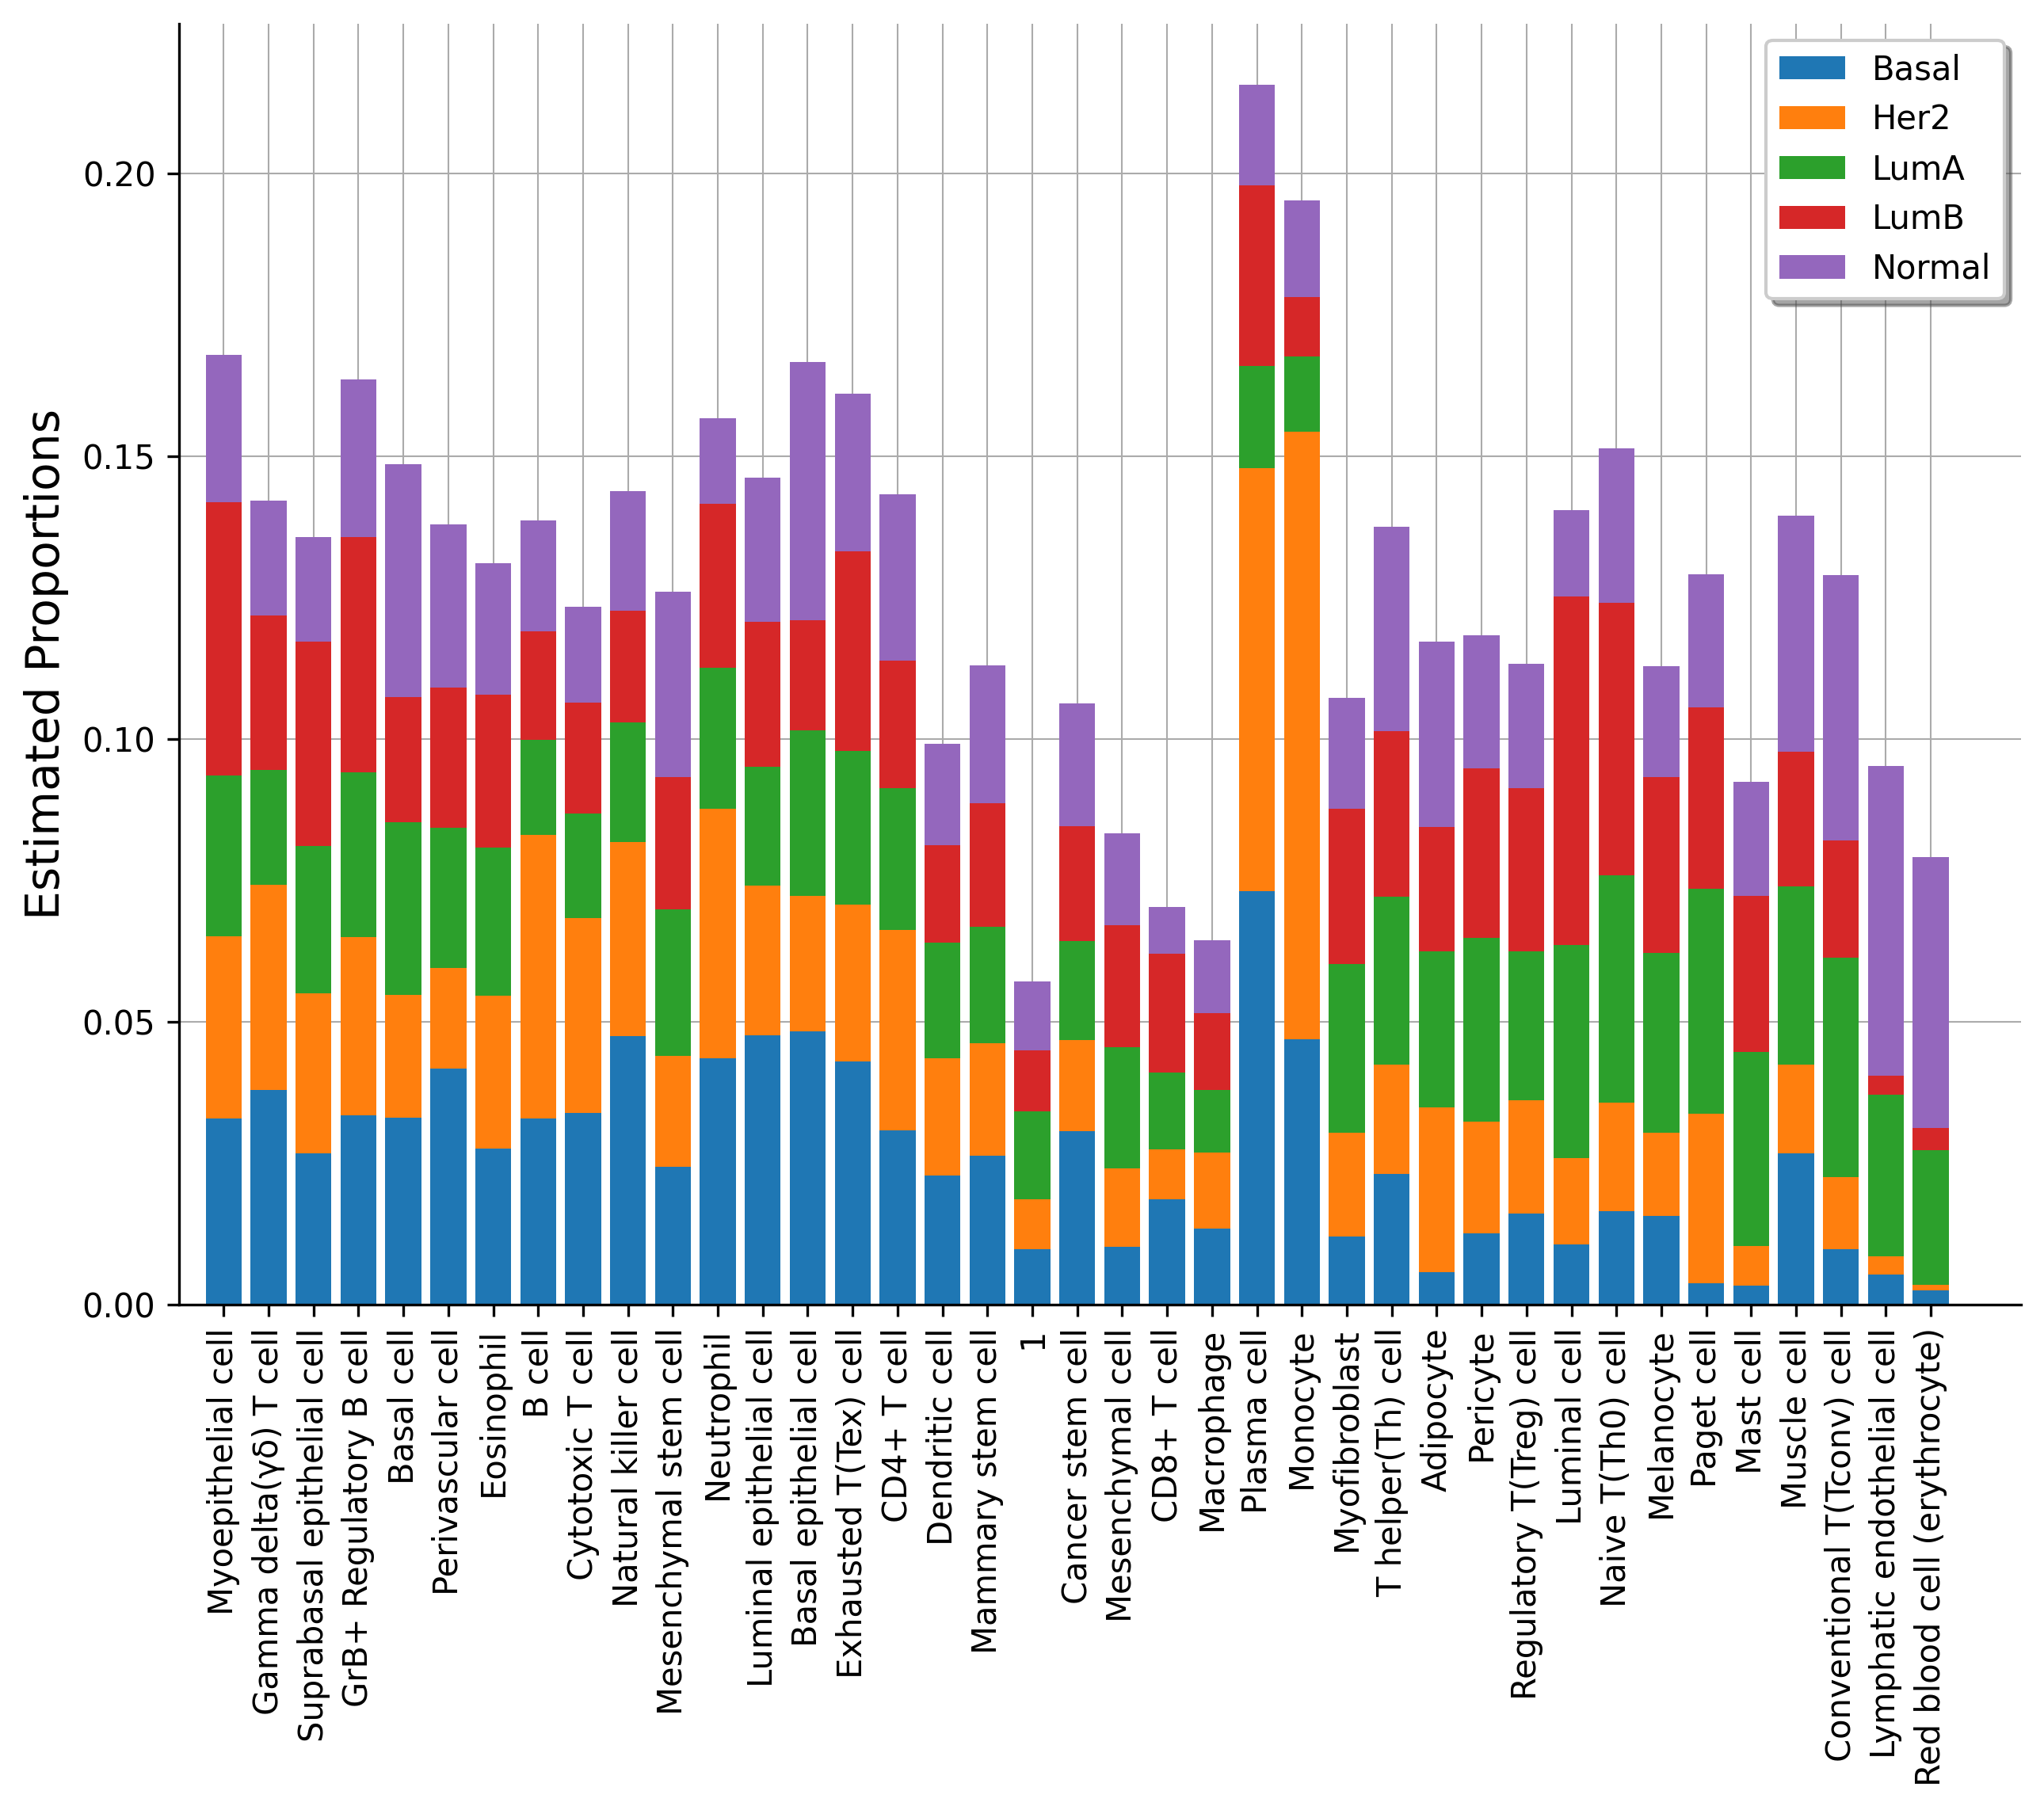

In [11]:
# %% Stacked barplots
dft = pd.DataFrame(data,index=target_type,columns=brca_res.columns.tolist()).T

# KMeans for setting cells order
from sklearn.cluster import KMeans

pred = KMeans(n_clusters=5,random_state=123).fit_predict(dft)
dft['pred'] = pred
dft = dft.sort_values('pred')
sorted_cells = dft.index.tolist()
cell_ids = ['{}'.format(i+1) for i in range(len(sorted_cells))]

conditions = ['Basal','Her2','LumA','LumB','Normal']
data = list(np.array(dft[conditions].T))

fig,ax = plt.subplots(figsize=(10,7),dpi=300)
x = [i for i in range(len(dft))]
y1 = np.array(dft['Basal'].tolist())
y2 = np.array(dft['Her2'].tolist())
y3 = np.array(dft['LumA'].tolist())
y4 = np.array(dft['LumB'].tolist())
y5 = np.array(dft['Normal'].tolist())
ax.bar(x,y1,label='Basal')
ax.bar(x,y2,label='Her2',bottom=y1)
ax.bar(x,y3,label='LumA',bottom=y1+y2)
ax.bar(x,y4,label='LumB',bottom=y1+y2+y3)
ax.bar(x,y5,label='Normal',bottom=y1+y2+y3+y4)

ax.set_ylabel("Estimated Proportions", fontsize=14)
plt.xticks(x,dft.index.tolist(),rotation=90)
plt.legend(shadow=True)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
ax.set_axisbelow(True)
ax.grid(color="#ababab",linewidth=0.5)
ax.set_xlim(-1,40)
plt.show()

***
#### Survival analysi on BRCA patients.
- Tumor samples were sorted according to the estimated proportion of specific cell types, and Cox proportional hazards regression was used to calculate survival rates between the top and bottom 25% of the samples.

In [7]:
brca_df = pd.read_table('/workspace/TCGA/tpm/TPM_TCGA-BRCA.txt',index_col=0) # local data
clinical = pd.read_table('/workspace/TCGA/info/clinical.tsv') # local data

# comprehensive analysis
dat = tu.TCGA_Analysis()
dat.set_data(exp=brca_df,deconv_res=deconv_res,clinical=clinical)
dat.preprocessing(lower_days=0,upper_days=3650)
summary = pd.DataFrame()
for cell in deconv_res.columns:
    dat.calc_top_bottom(cell=cell,do_plot=False) # top 25% and bottom 25%
    res_log = dat.res_log
    summary = pd.concat([summary,res_log])
summary.index = deconv_res.columns
summary = summary.sort_values('log-rank')

/workspace/github/GLDADec/_utils/tcga_utils.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prognosis["OS_Time"] = prognosis["OS_Time"].apply(fxn)
/workspace/github/GLDADec/_utils/tcga_utils.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prognosis["OS_Status"] = prog_status


/workspace/github/GLDADec/_utils/tcga_utils.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prognosis["OS_Time"] = prognosis["OS_Time"].apply(fxn)
/workspace/github/GLDADec/_utils/tcga_utils.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prognosis["OS_Status"] = prog_status


<lifelines.CoxPHFitter: fitted with 393 total observations, 376 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 17
   partial log-likelihood = -78.56
         time fit was run = 2024-04-02 05:31:15 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Mesenchymal cell   2.19       8.91       0.75             0.71             3.66                 2.03                39.01

                   cmp to    z      p   -log2(p)
covariate                                       
Mesenchymal cell     0.00 2.90 <0.005       8.07
---
Concordance = 0.65
Partial AIC = 159.13
log-likelihood ratio test = 13.55 on 1 df
-log2(p) of ll-ratio test = 12.07

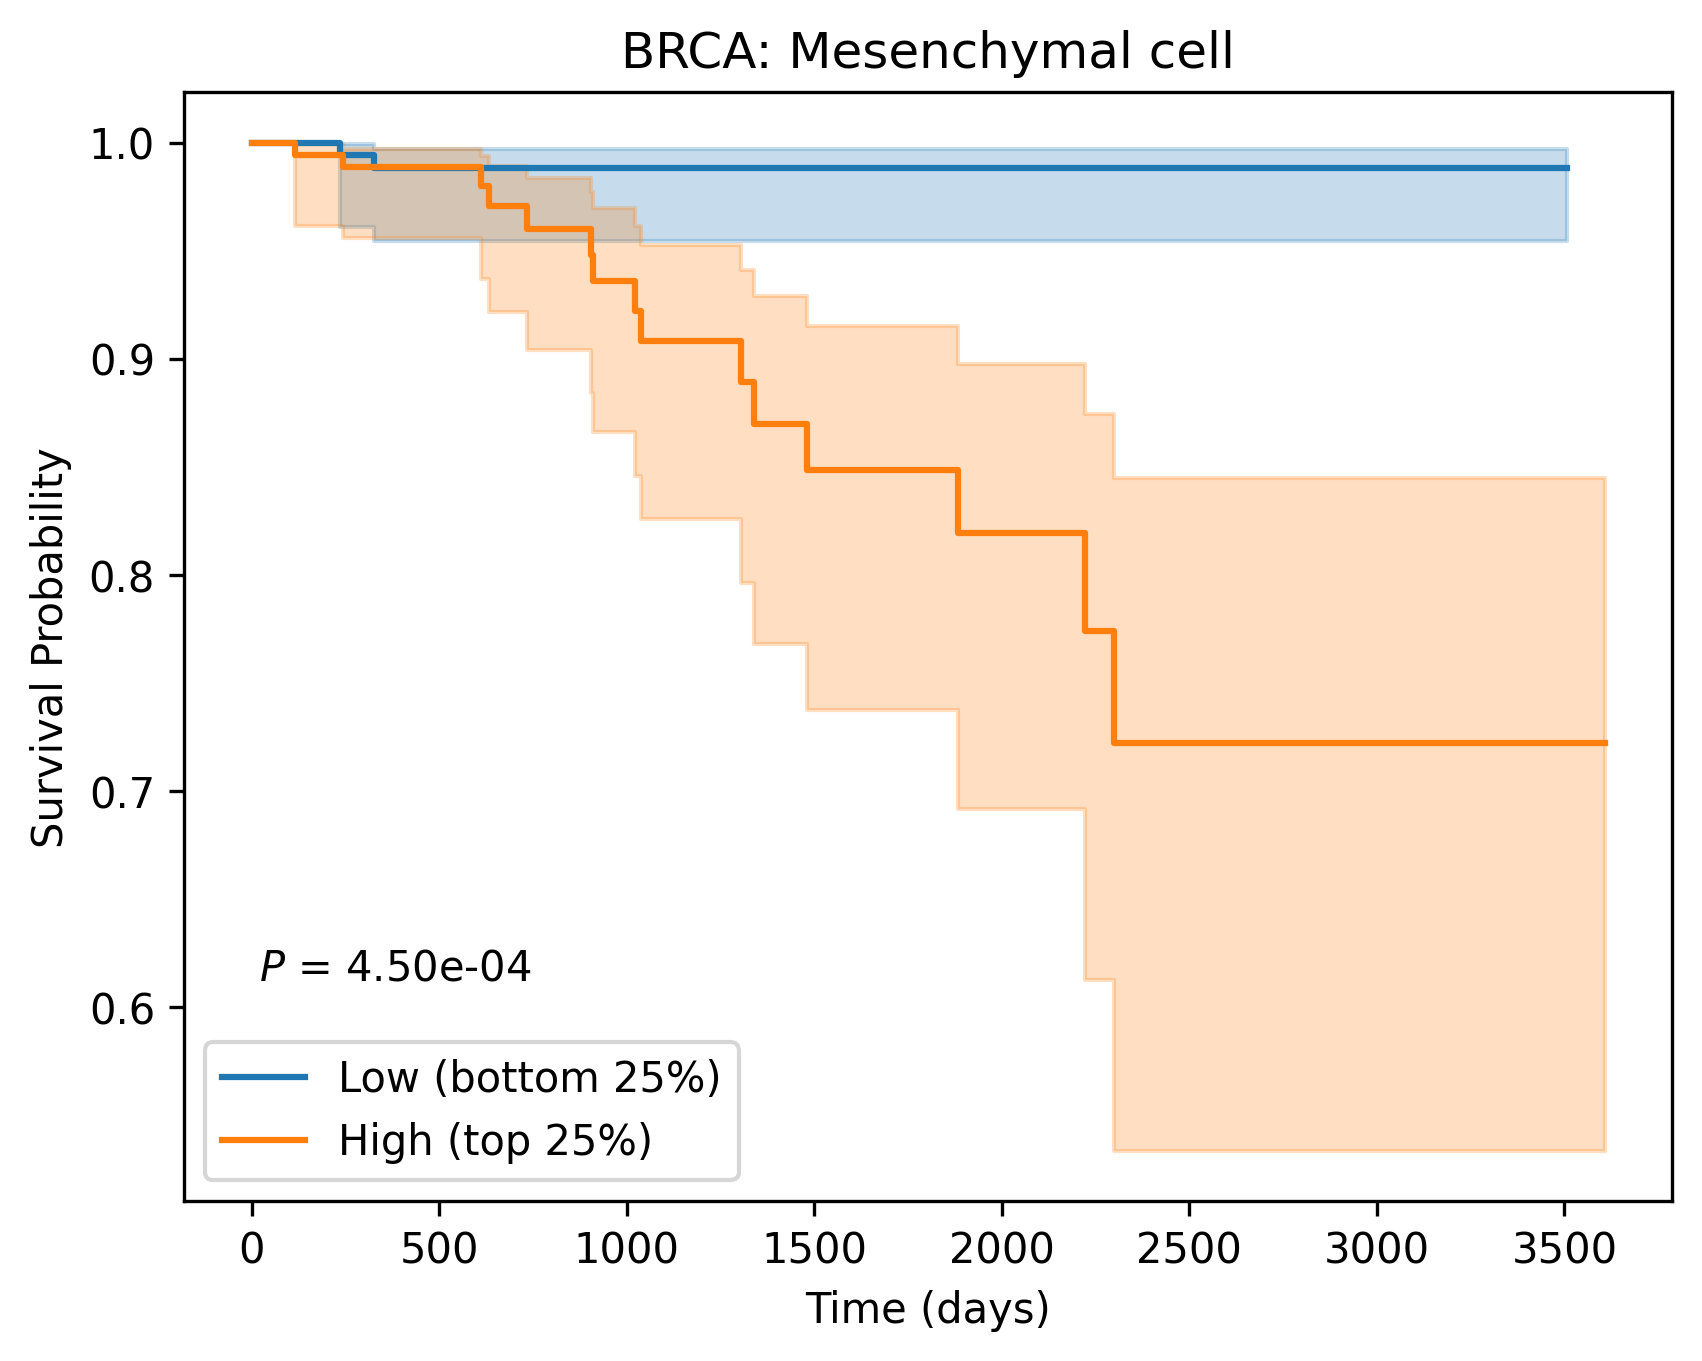

<lifelines.CoxPHFitter: fitted with 393 total observations, 377 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 16
   partial log-likelihood = -72.55
         time fit was run = 2024-04-02 05:31:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Pericyte    2.14       8.47       0.76             0.65             3.62                 1.92                37.33

            cmp to    z      p   -log2(p)
covariate                                
Pericyte      0.00 2.82 <0.005       7.72
---
Concordance = 0.64
Partial AIC = 147.10
log-likelihood ratio test = 12.50 on 1 df
-log2(p) of ll-ratio test = 11.26

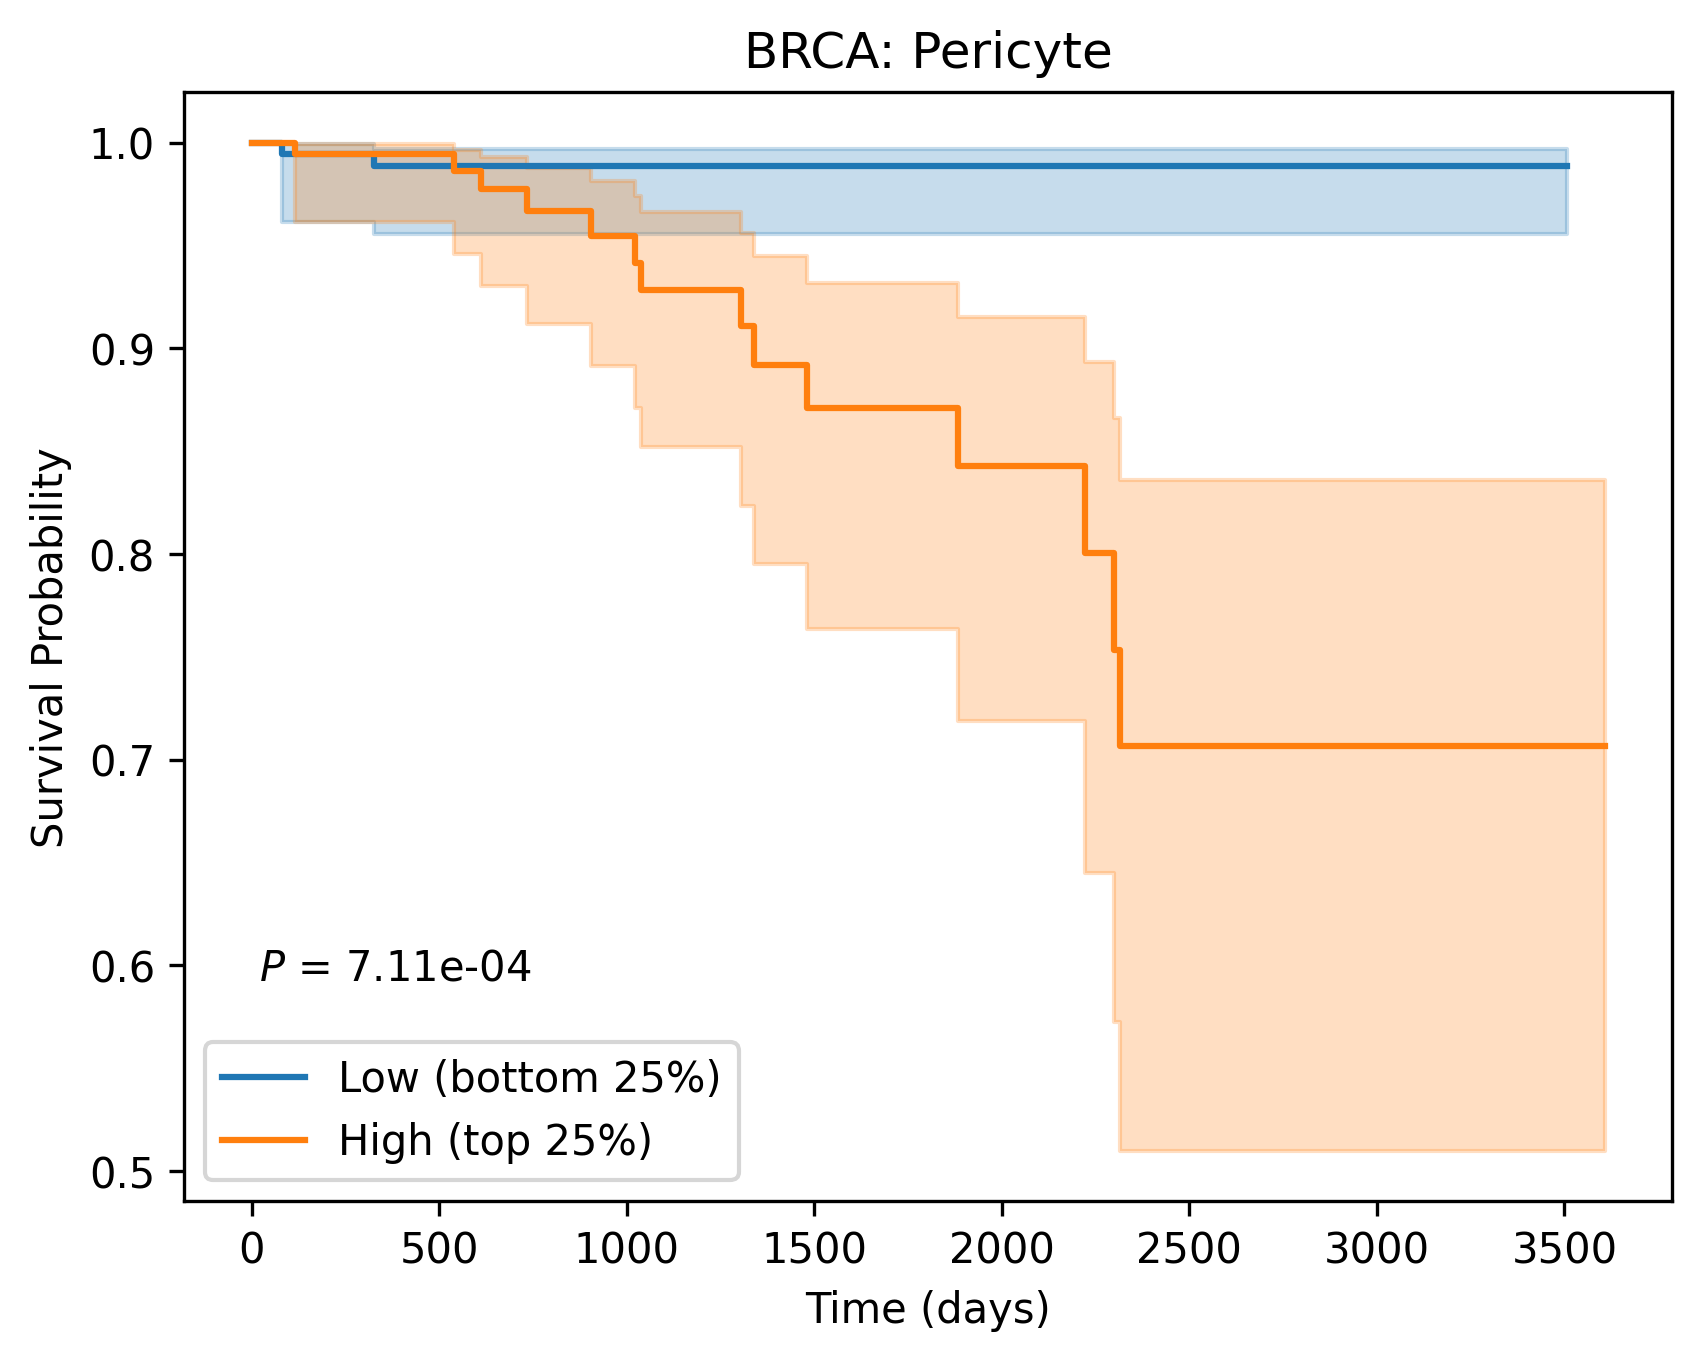

<lifelines.CoxPHFitter: fitted with 393 total observations, 380 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 13
   partial log-likelihood = -62.24
         time fit was run = 2024-04-02 05:31:16 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
Plasma cell  -2.50       0.08       1.04            -4.54            -0.46                 0.01                 0.63

              cmp to     z    p   -log2(p)
covariate                                 
Plasma cell     0.00 -2.40 0.02       5.94
---
Concordance = 0.72
Partial AIC = 126.48
log-likelihood ratio test = 11.11 on 1 df
-log2(p) of ll-ratio test = 10.18

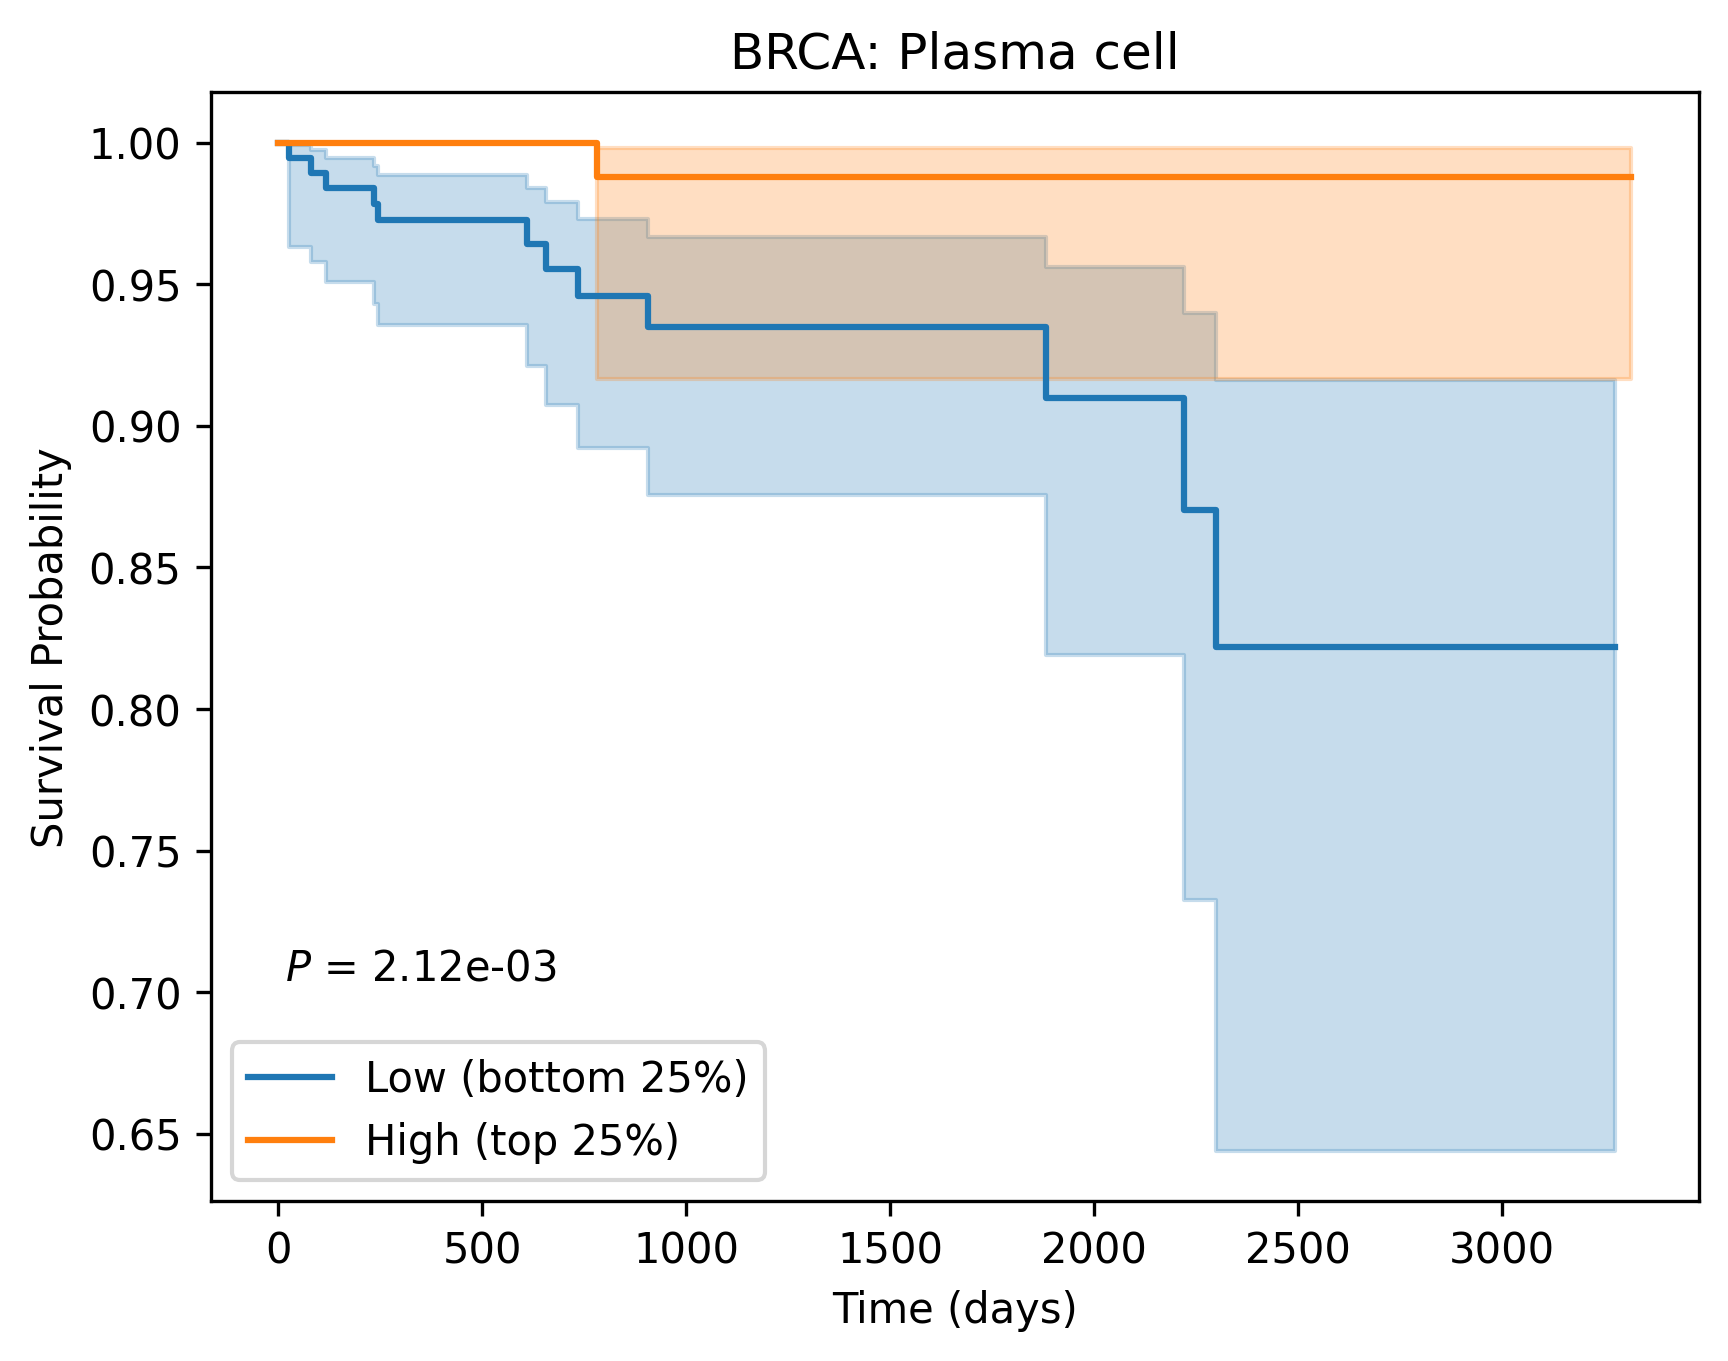

<lifelines.CoxPHFitter: fitted with 393 total observations, 381 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 12
   partial log-likelihood = -53.21
         time fit was run = 2024-04-02 05:31:17 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Mast cell   2.44      11.46       1.05             0.39             4.49                 1.48                88.88

            cmp to    z    p   -log2(p)
covariate                              
Mast cell     0.00 2.33 0.02       5.67
---
Concordance = 0.67
Partial AIC = 108.42
log-likelihood ratio test = 10.13 on 1 df
-log2(p) of ll-ratio test = 9.42

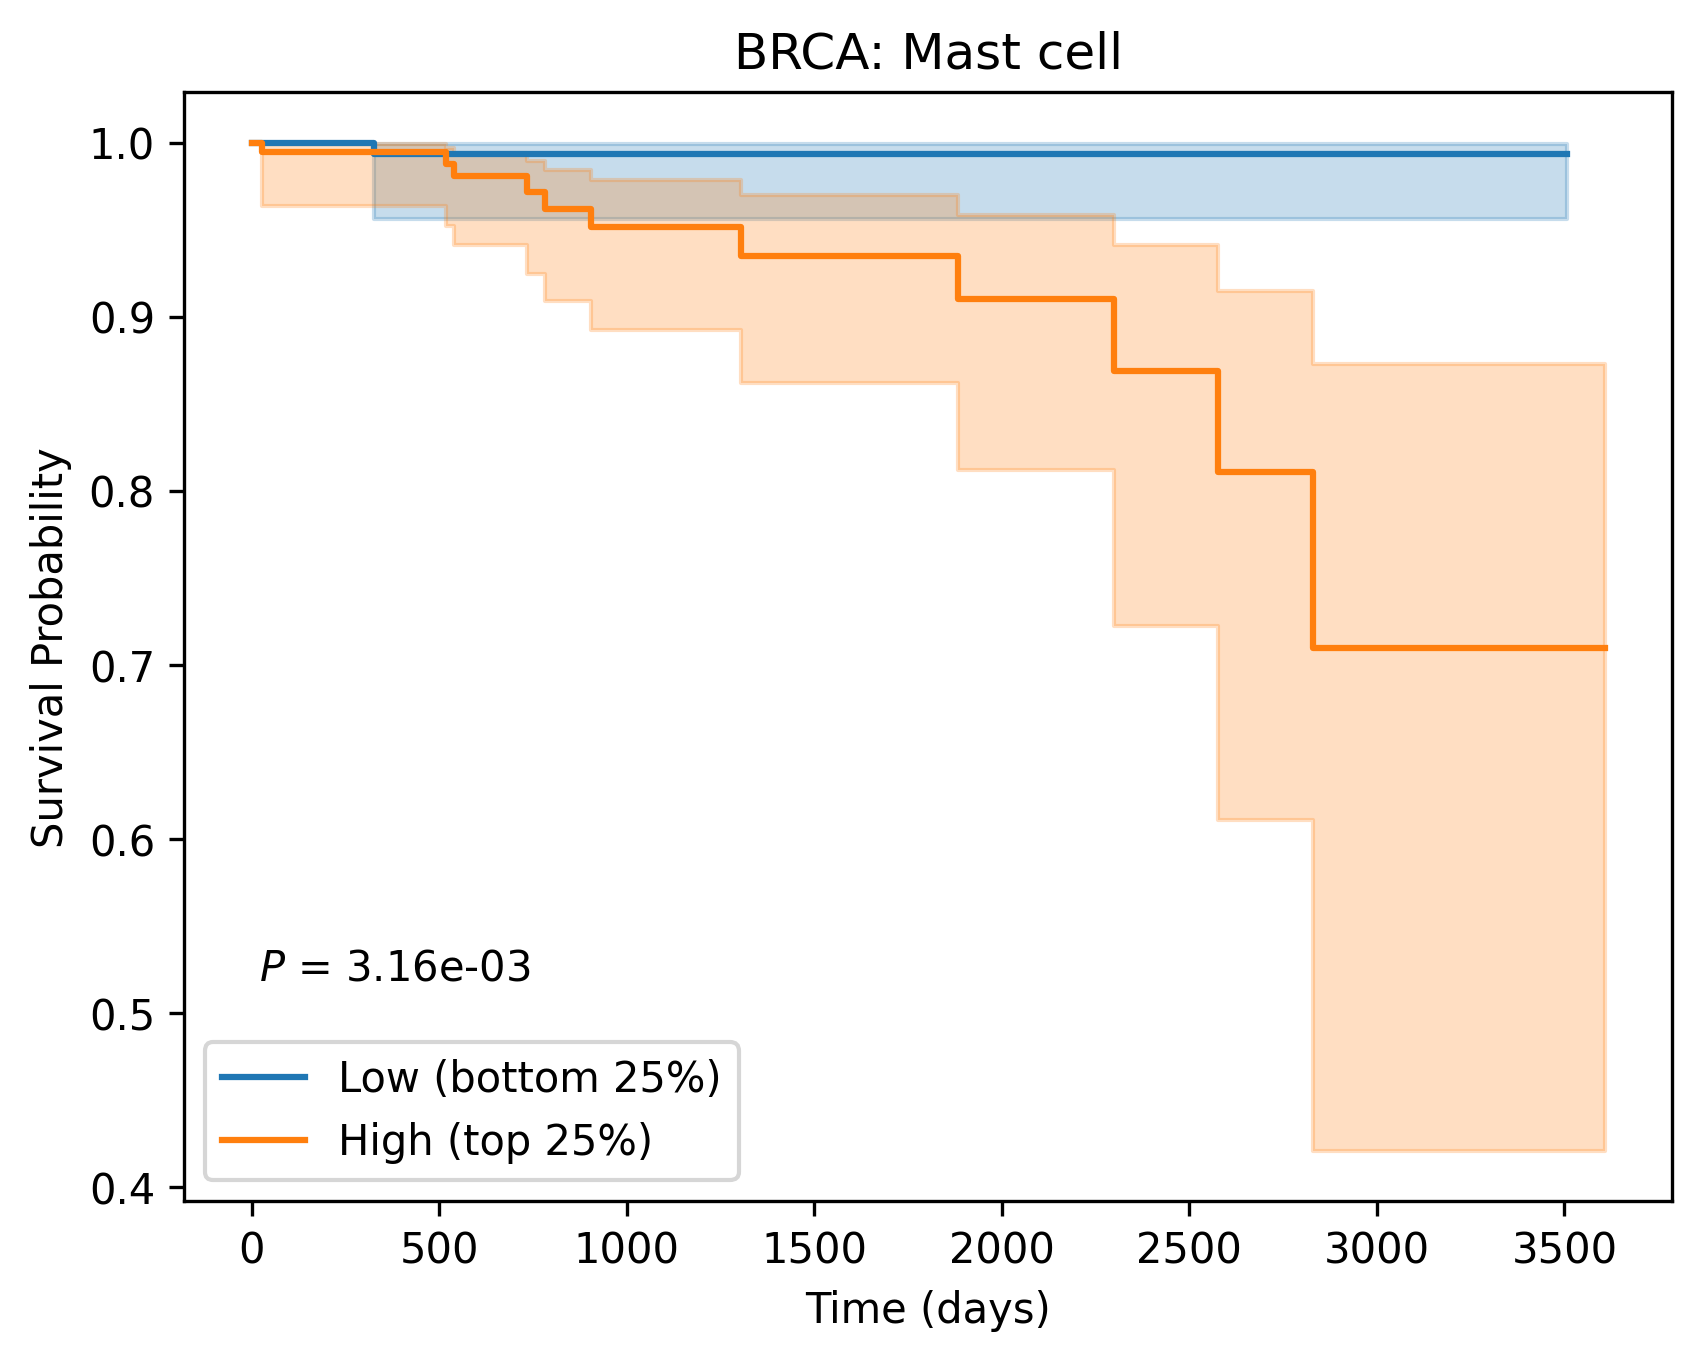

<lifelines.CoxPHFitter: fitted with 393 total observations, 375 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 18
   partial log-likelihood = -91.28
         time fit was run = 2024-04-02 05:31:17 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
Gamma delta(γδ) T cell  -1.54       0.22       0.57            -2.66            -0.41                 0.07                 0.66

                         cmp to     z    p   -log2(p)
covariate                                            
Gamma delta(γδ) T cell     0.00 -2.67 0.01       7.06
---
Concordance = 0.63
Partial AIC = 184.56
log-likelihood ratio test = 8.79 on 1 df
-log2(p) of ll-ratio test = 8.37

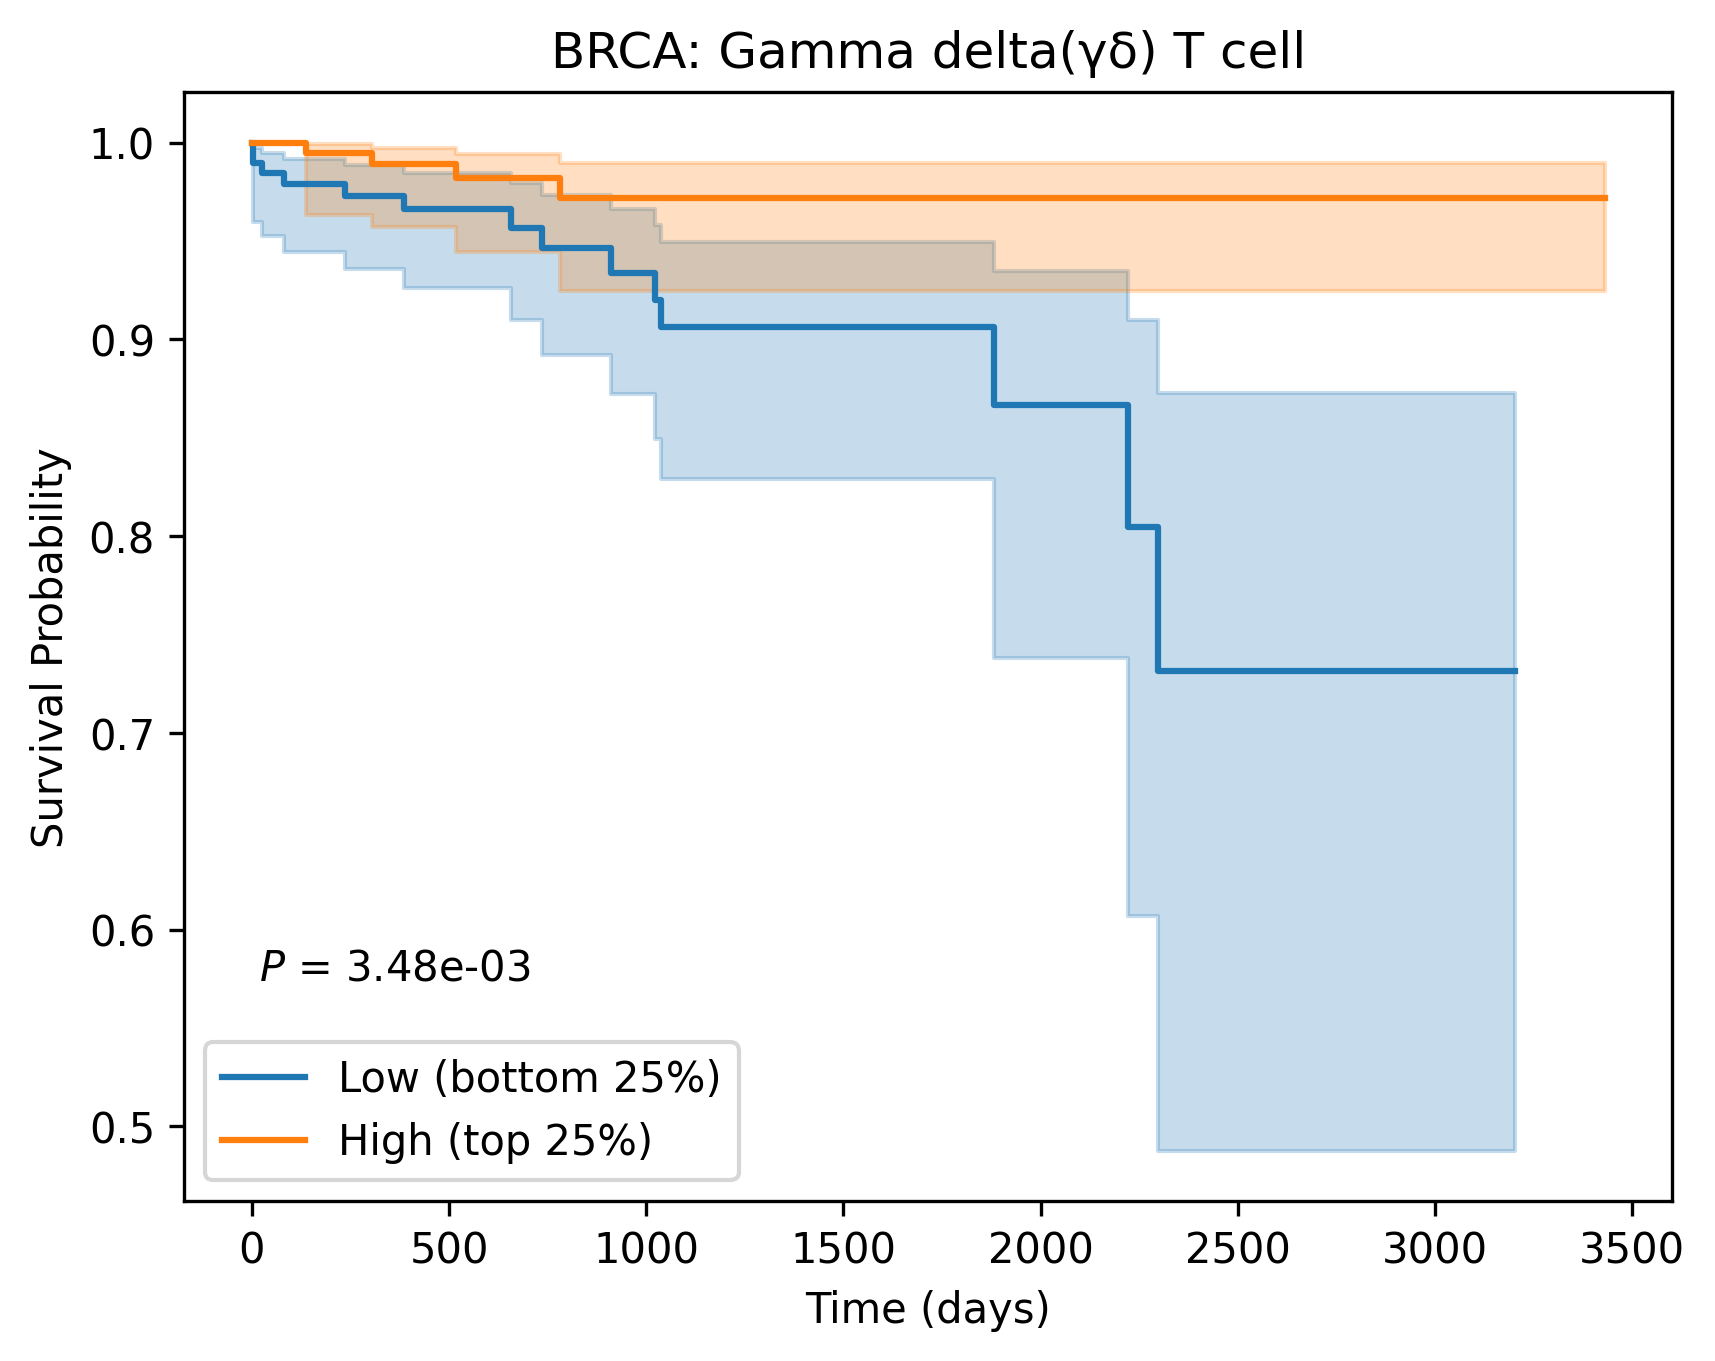

<lifelines.CoxPHFitter: fitted with 393 total observations, 375 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 18
   partial log-likelihood = -85.68
         time fit was run = 2024-04-02 05:31:18 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
Myofibroblast   1.46       4.30       0.57             0.34             2.57                 1.41                13.08

                cmp to    z    p   -log2(p)
covariate                                  
Myofibroblast     0.00 2.57 0.01       6.61
---
Concordance = 0.57
Partial AIC = 173.36
log-likelihood ratio test = 8.08 on 1 df
-log2(p) of ll-ratio test = 7.81

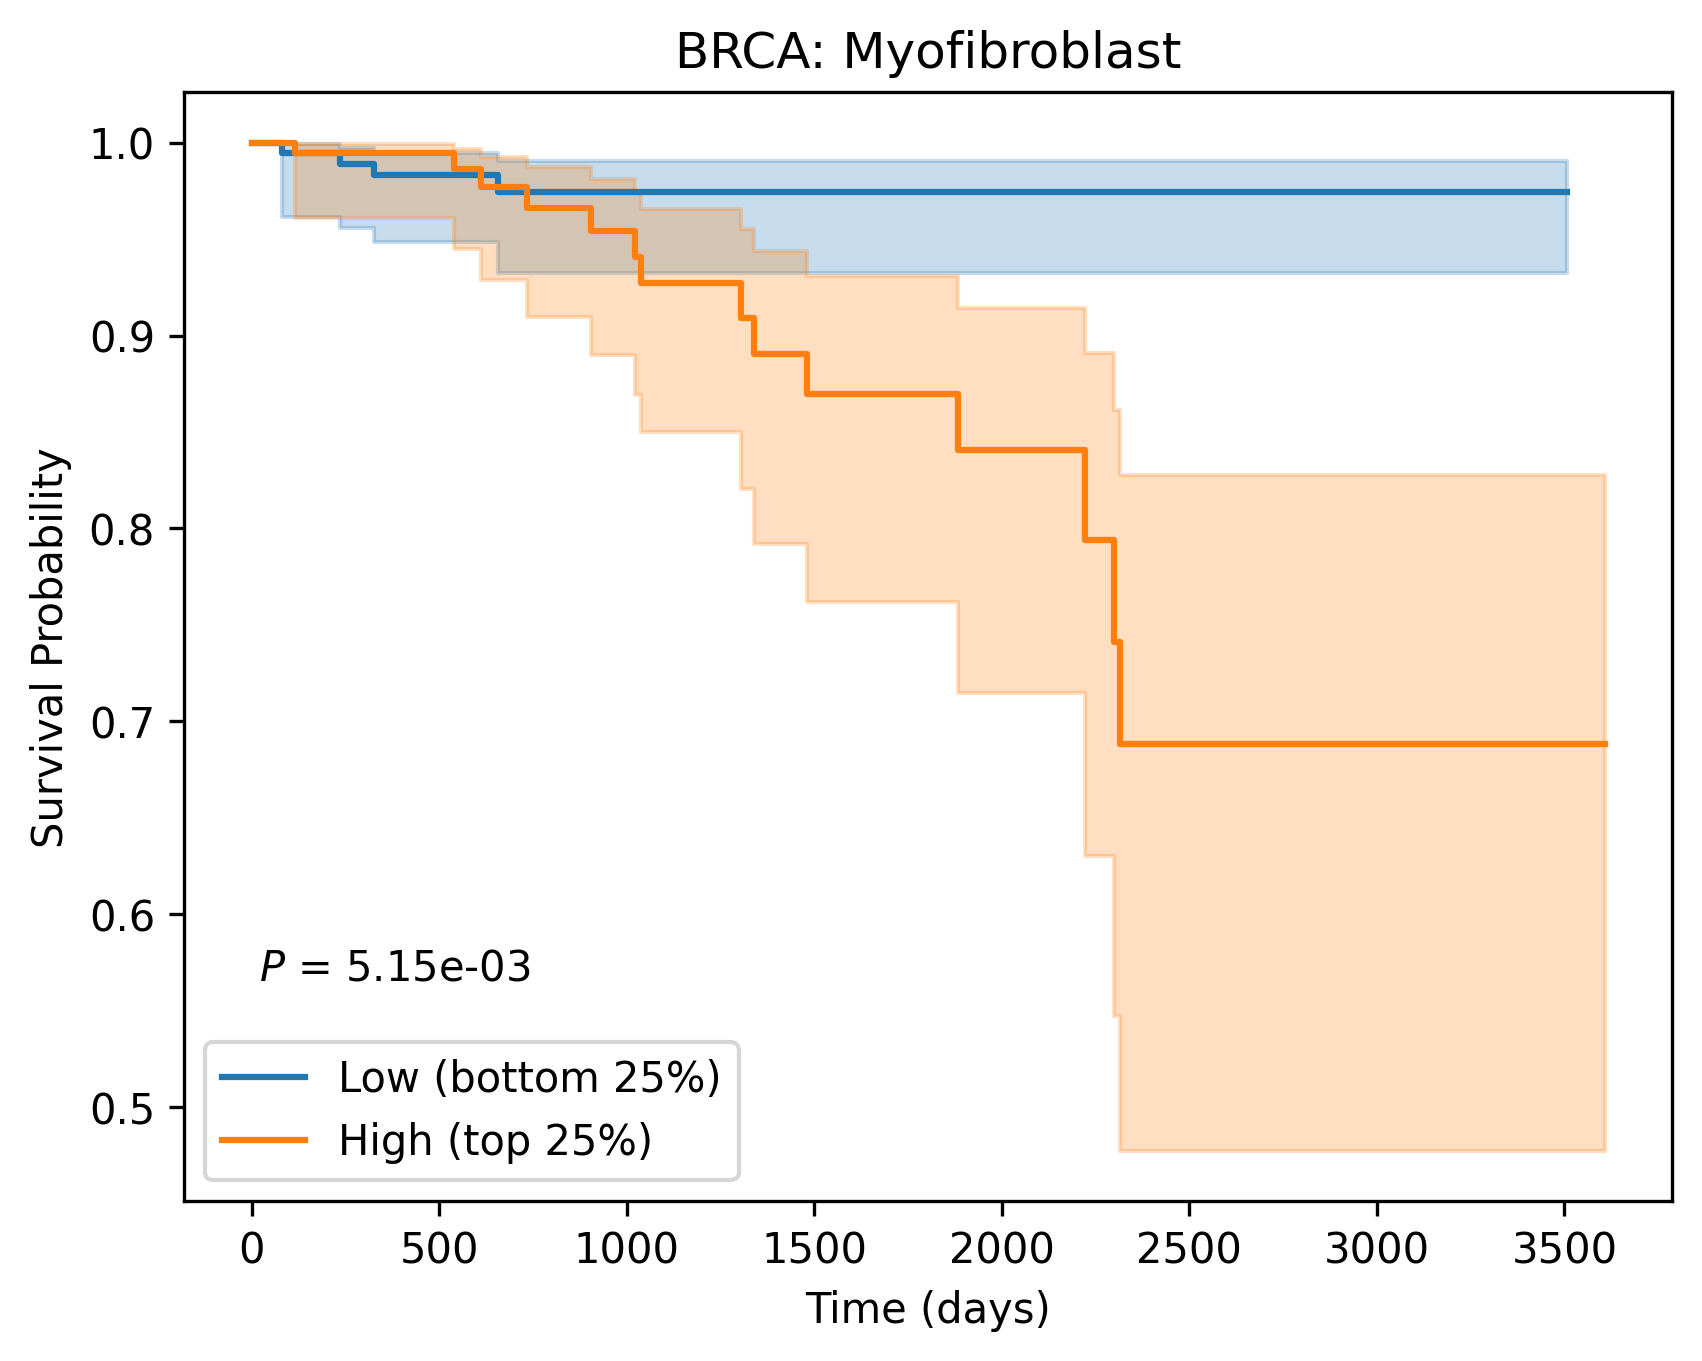

<lifelines.CoxPHFitter: fitted with 393 total observations, 375 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 18
   partial log-likelihood = -90.42
         time fit was run = 2024-04-02 05:31:18 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Luminal epithelial cell  -1.56       0.21       0.63            -2.80            -0.32                 0.06                 0.73

                          cmp to     z    p   -log2(p)
covariate                                             
Luminal epithelial cell     0.00 -2.46 0.01       6.17
---
Concordance = 0.69
Partial AIC = 182.84
log-likelihood ratio test = 8.09 on 1 df
-log2(p) of ll-ratio test = 7.82

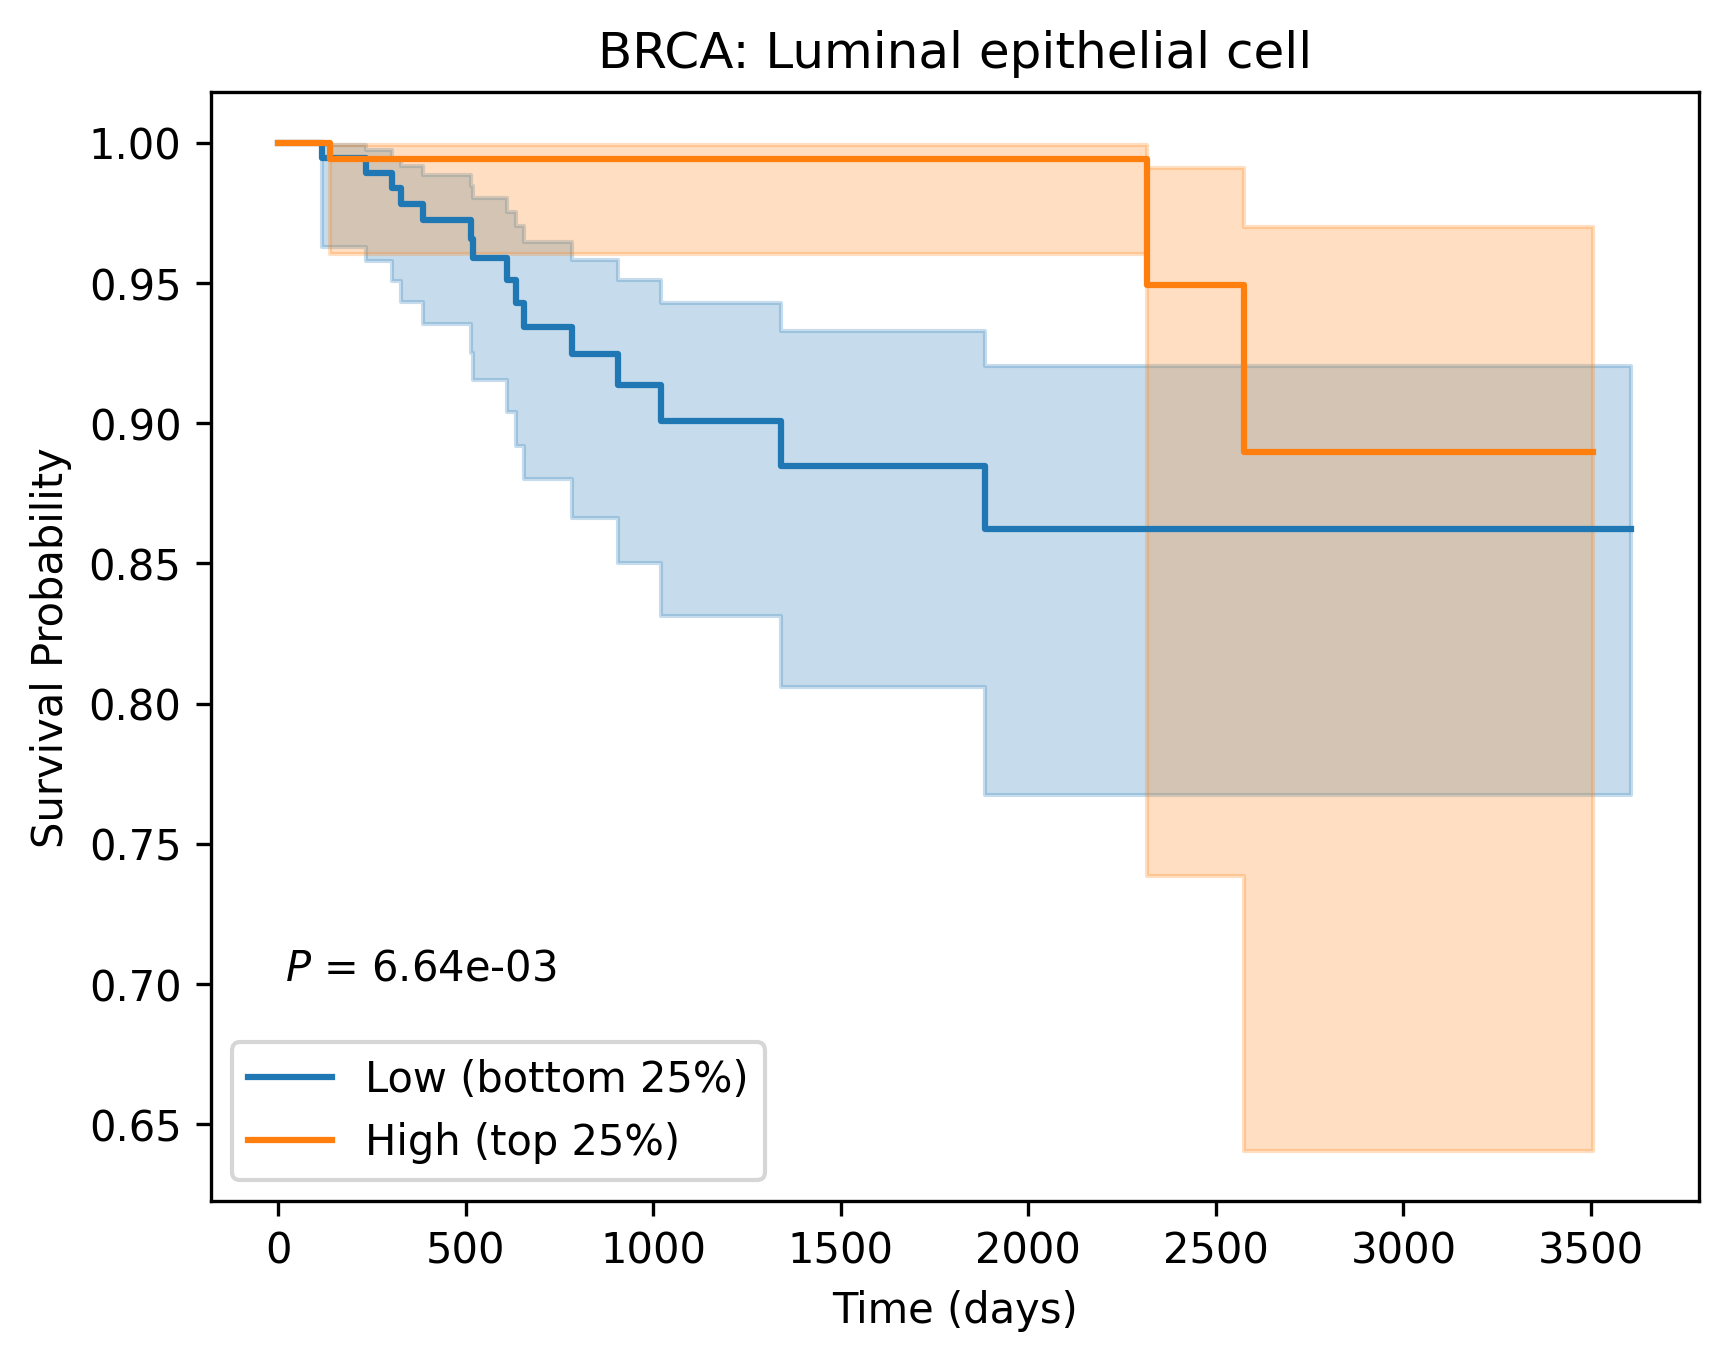

<lifelines.CoxPHFitter: fitted with 392 total observations, 375 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 392
number of events observed = 17
   partial log-likelihood = -84.62
         time fit was run = 2024-04-02 05:31:19 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
CD4+ T cell  -1.22       0.29       0.54            -2.28            -0.17                 0.10                 0.84

              cmp to     z    p   -log2(p)
covariate                                 
CD4+ T cell     0.00 -2.28 0.02       5.45
---
Concordance = 0.58
Partial AIC = 171.24
log-likelihood ratio test = 5.79 on 1 df
-log2(p) of ll-ratio test = 5.95

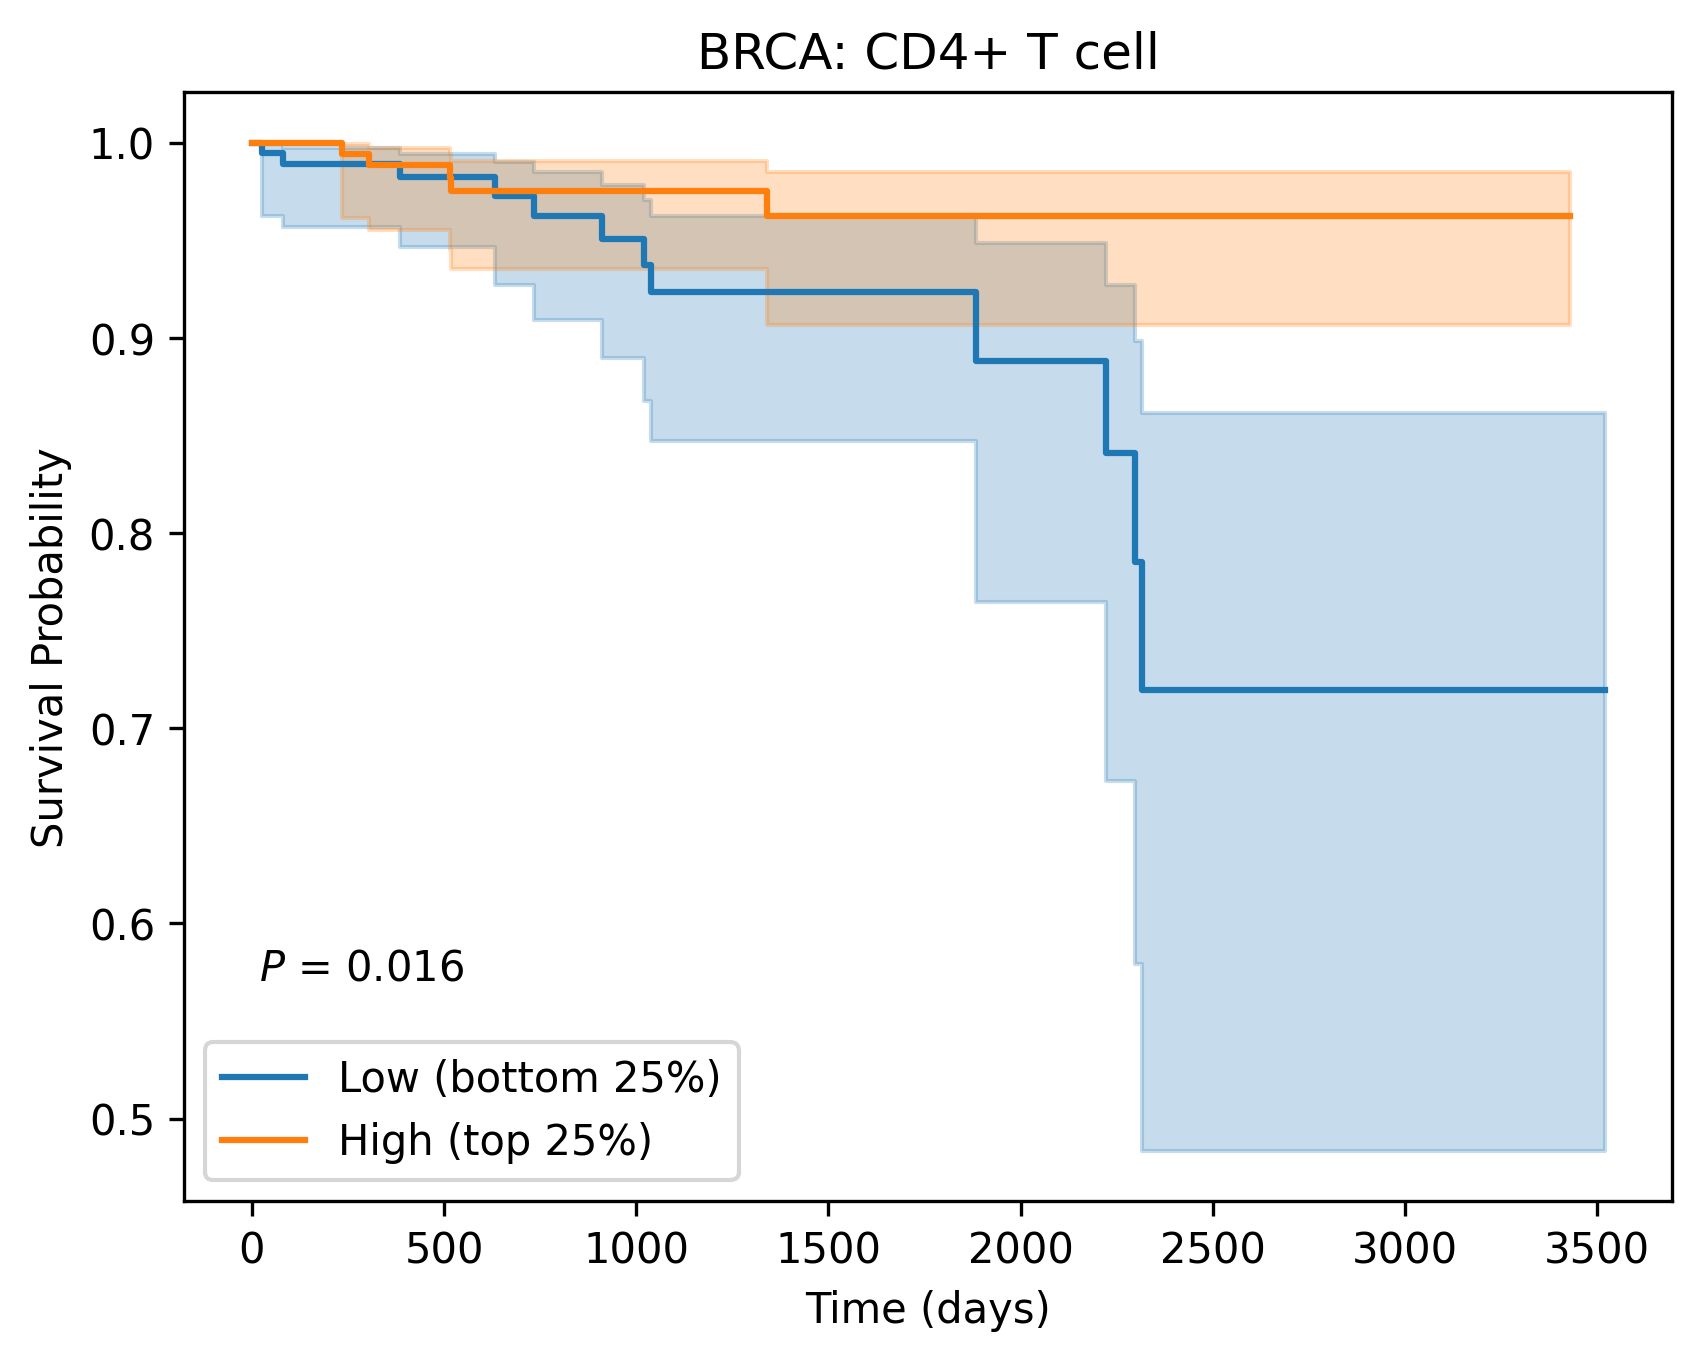

<lifelines.CoxPHFitter: fitted with 392 total observations, 375 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 392
number of events observed = 17
   partial log-likelihood = -85.30
         time fit was run = 2024-04-02 05:31:19 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Cytotoxic T cell  -1.22       0.30       0.54            -2.28            -0.16                 0.10                 0.85

                   cmp to     z    p   -log2(p)
covariate                                      
Cytotoxic T cell     0.00 -2.26 0.02       5.39
---
Concordance = 0.60
Partial AIC = 172.59
log-likelihood ratio test = 5.71 on 1 df
-log2(p) of ll-ratio test = 5.89

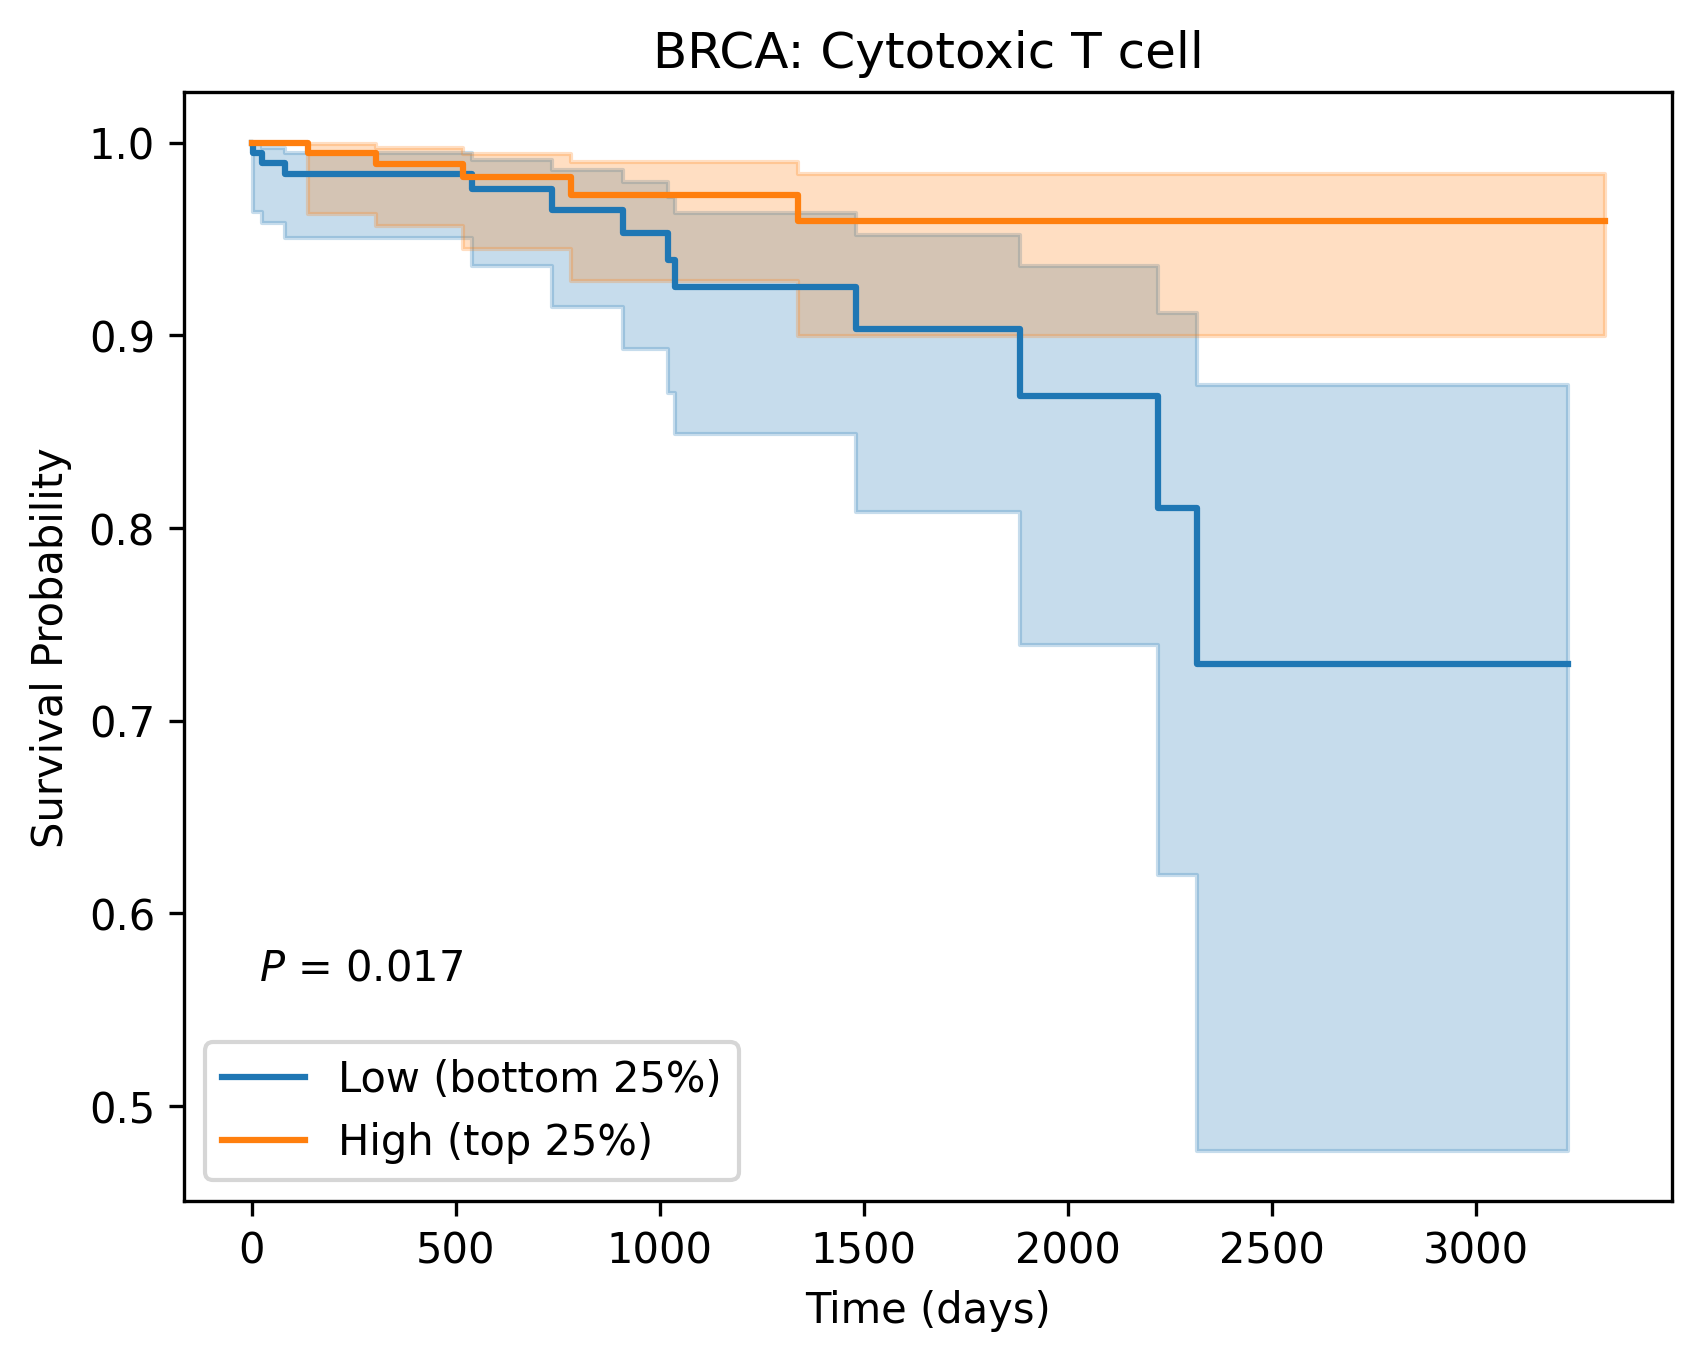

In [8]:
# select interesting cell types and re-analysis
target_summary = summary[summary['log-rank']<0.05]

dat = tu.TCGA_Analysis()
dat.set_data(exp=brca_df,deconv_res=deconv_res,clinical=clinical)
dat.preprocessing(lower_days=0,upper_days=3650)
for cell in target_summary.index:
    dat.calc_top_bottom(cell=cell,do_plot=True,title='BRCA: {}'.format(cell))